# Python Data Analysis for Radiotherapy Applications

## Contents:
* Dose map with gammas and protons in external RT
* Dose map analysis for internal RT
* PhSp files: reading IEAE and ROOT formats
* GateTools

# Dose map analysis with the example Ex_dose3D

#### We will first have a look at a GATE example to produce a 3D dose map:
* open a terminal and go to the folder gate_radiotherapy/Ex_dose3D
* look at the different files and open mac/main.mac
* look at all the sections and in particular to the geometry and ouputs section
* run the example with  
`Gate --qt mac/main.mac`
* check the output folder and the different files produced
* analyse the output 3D dose map with the following cells  
(some high statistic results with 1e6 particles are available in results.1e6/)

In [1]:
cd Ex_dose3D/

/home/mverdier/Documents/IMNC/Gate_SC/Formation_CNRS/2022/Wednesday/Gate_Radiotherapy/Ex_dose3D


In [2]:
pwd

'/home/mverdier/Documents/IMNC/Gate_SC/Formation_CNRS/2022/Wednesday/Gate_Radiotherapy/Ex_dose3D'

In [3]:
ls

data/  mac/  main.mac  output/  README.md  results.1e6/


In [4]:
cat main.mac

#=====================================================
# VERBOSITY
#=====================================================

/control/execute    mac/verbose.mac

#=====================================================
# GEOMETRY
#=====================================================


/gate/geometry/setMaterialDatabase  data/GateMaterials.db

# World
/gate/world/geometry/setXLength     1 m
/gate/world/geometry/setYLength     1 m
/gate/world/geometry/setZLength     1 m
/gate/world/setMaterial             Air

# Generate materials from Hounsfield units
/gate/HounsfieldMaterialGenerator/SetMaterialTable                  data/Schneider2000MaterialsTable.txt
/gate/HounsfieldMaterialGenerator/SetDensityTable                   data/Schneider2000DensitiesTable.txt
/gate/HounsfieldMaterialGenerator/SetDensityTolerance               0.1 g/cm3
/gate/HounsfieldMaterialGenerator/SetOutputMaterialDatabaseFilename data/patient-HUmaterials.db
/gate/HounsfieldMaterialGenerator/SetOutputHUMaterialFilename 

In [5]:
!Gate main.mac

[G4] 
[G4] **************************************************************
[G4]  Geant4 version Name: geant4-10-07-patch-02    (11-June-2021)
[G4]                        Copyright : Geant4 Collaboration
[G4]                       References : NIM A 506 (2003), 250-303
[G4]                                  : IEEE-TNS 53 (2006), 270-278
[G4]                                  : NIM A 835 (2016), 186-225
[G4]                              WWW : http://geant4.org/
[G4] **************************************************************
[G4] 
[Core-0] Initialization of geometry
[Core-0] Initialization of physics
[Core-0] Initialization of actors
[G4] Available UI session types: [ Qt, GAG, tcsh, csh ]
[Core-0] 
[Core-0] *************************************************
[Core-0]  GATE version 9.1 (2021)
[Core-0]  Copyright : OpenGATE Collaboration
[Core-0]  Reference : Phys. Med. Biol. 49 (2004) 4543-4561
[Core-0]  Reference : Phys. Med. Biol. 56 (2011) 881-901
[Core-0]  Reference : Med. Phys. 41(6)  

In [26]:
import numpy as np
import SimpleITK as sitk
import ipywidgets as ipw
# to enable interactive widgets in jupyter notebook run this command in a terminal:
#jupyter nbextension enable --py widgetsnbextension
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import uproot


In [7]:
# Read the patient CT with sitk
img_ct = sitk.ReadImage('data/patient-2mm.mhd')

print('Image size: ', img_ct.GetSize())
print('Image spacing: ', img_ct.GetSpacing())
print('Image origin: ', img_ct.GetOrigin())

Image size:  (126, 126, 111)
Image spacing:  (2.0, 2.0, 2.0)
Image origin:  (0.0, 0.0, 0.0)


In [8]:
# Convert sitk image to a numpy array
arr_ct = sitk.GetArrayFromImage(img_ct)
print('Array size: ', arr_ct.shape, ' <--- be careful to the dimension order!)')

Array size:  (111, 126, 126)  <--- be careful to the dimension order!)


In [9]:


# function to display 3D image slices
def show_ct(sx,sy,sz):
    fig, ax = plt.subplots(1, 3, figsize=(16, 8)) # Create an array of axes : 1 row, 3 columns
    ax[0].imshow(arr_ct[sx, :, :], origin='lower', cmap='bone', vmin=arr_ct.min(), vmax=arr_ct.max()*0.7)
    ax[1].imshow(arr_ct[:, sy, :], origin='lower', cmap='bone', vmin=arr_ct.min(), vmax=arr_ct.max()*0.7)
    ax[2].imshow(arr_ct[:, :, sz], origin='lower', cmap='bone', vmin=arr_ct.min(), vmax=arr_ct.max()*0.7)
    plt.show()
    
ipw.interact(show_ct, sx=(0,arr_ct.shape[0]-1), sy=(0,arr_ct.shape[1]-1), sz=(0,arr_ct.shape[2]-1));

interactive(children=(IntSlider(value=55, description='sx', max=110), IntSlider(value=62, description='sy', ma…

In [10]:
# read the GATE output result
img_dose = sitk.ReadImage('output/3d-Dose.mhd')
# img_dose = sitk.ReadImage('Ex_dose3D/results.1e6/3d-gamma-Dose.mhd')
arr_dose = sitk.GetArrayFromImage(img_dose)
print('Image size = ', arr_dose.shape)
print('Image min and max: ', np.min(arr_dose), np.max(arr_dose))

Image size =  (50, 50, 50)
Image min and max:  0.0 2.3486228e-08


In [11]:
# display the output result
def show_dose(nslice):
    plt.figure()
    plt.imshow(arr_dose[:, :, nslice], cmap='hot', vmin=0, vmax=arr_dose.max())
    plt.colorbar()
    plt.show()
    
ipw.interact(show_dose, nslice=(0, arr_dose.shape[2]-1));

interactive(children=(IntSlider(value=24, description='nslice', max=49), Output()), _dom_classes=('widget-inte…

In [12]:
# resample the dose map to match the CT resolution
img_resampled_dose = sitk.Resample(img_dose, img_ct, sitk.Transform(), sitk.sitkLinear, 0)
arr_resampled_dose = sitk.GetArrayFromImage(img_resampled_dose)
print('Image size = ', arr_resampled_dose.shape)
print('Image min and max: ',  np.min(arr_resampled_dose), np.max(arr_resampled_dose))

Image size =  (111, 126, 126)
Image min and max:  0.0 1.9964263e-08


In [13]:
# function to overlay the CT and the dose map
def show_fusion(nslice=64, opacity=0.7):
    min_dose_disp = 1e-9
    plt.figure(figsize=(10, 7))
    plt.imshow(arr_ct[:, :, nslice], vmin=arr_ct.min(), vmax=arr_ct.max(), cmap='bone')
    a = arr_resampled_dose[:, :, nslice]
    b = np.ma.masked_where(a <= min_dose_disp, a)
    plt.imshow(b, alpha=opacity, cmap='hot', vmin=min_dose_disp, vmax=arr_resampled_dose.max())
    plt.colorbar()
    plt.show()
    
ipw.interact(show_fusion, nslice=(0, arr_ct.shape[2]-1), opacity=(0, 1, 0.1));

interactive(children=(IntSlider(value=64, description='nslice', max=125), FloatSlider(value=0.7, description='…

## Exercise
* make a depth dose plot
* change the particle type to 100 MeV protons in the main.mac
* run the exemple again and analyse the results
* explain the difference with gammas

(111,)


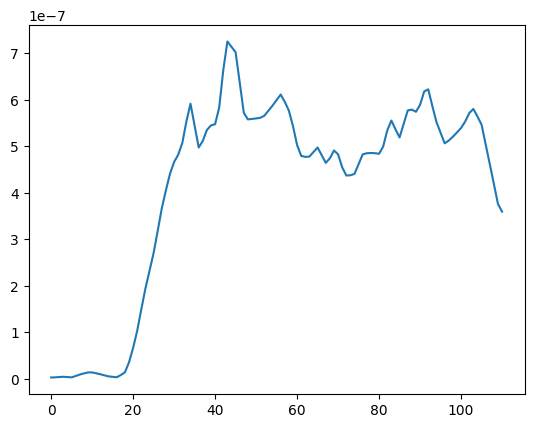

In [14]:
p_edep = arr_resampled_dose.sum(axis=(2, 1))
print(p_edep.shape)

plt.figure()
plt.plot(p_edep)
plt.show()

# Dose map analysis with the example Ex_internal-RT

## Exercise
* open a terminal and go to the folder gate_radiotherapy/Ex_Internal-RT
* look at the different files and open mac/main.mac
* run the example with  
`Gate --qt mac/main.mac`
* use this notebook to analyse the 3D dose map result (from the "dose map analysis" section)  
(some high statistic results with 1e6 particles are available in results.1e6/)
* display a slice of the 3D data with plt.imshow
* display a slice of the SPECT image with plt.imshow
* use the SPECT activity matrix to select a region in the dose map region and get the total aborbed dose in that region

In [15]:
cd ../Ex_InternalRT/

/home/mverdier/Documents/IMNC/Gate_SC/Formation_CNRS/2022/Wednesday/Gate_Radiotherapy/Ex_InternalRT


In [16]:
pwd

'/home/mverdier/Documents/IMNC/Gate_SC/Formation_CNRS/2022/Wednesday/Gate_Radiotherapy/Ex_InternalRT'

In [86]:
!Gate main.mac

[G4] 
[G4] **************************************************************
[G4]  Geant4 version Name: geant4-10-07-patch-02    (11-June-2021)
[G4]                        Copyright : Geant4 Collaboration
[G4]                       References : NIM A 506 (2003), 250-303
[G4]                                  : IEEE-TNS 53 (2006), 270-278
[G4]                                  : NIM A 835 (2016), 186-225
[G4]                              WWW : http://geant4.org/
[G4] **************************************************************
[G4] 
[Core-0] Initialization of geometry
[Core-0] Initialization of physics
[Core-0] Initialization of actors
[Core-0] 
[Core-0] *************************************************
[Core-0]  GATE version 9.1 (2021)
[Core-0]  Copyright : OpenGATE Collaboration
[Core-0]  Reference : Phys. Med. Biol. 49 (2004) 4543-4561
[Core-0]  Reference : Phys. Med. Biol. 56 (2011) 881-901
[Core-0]  Reference : Med. Phys. 41(6)    (2014)
[Core-0]  http://www.opengatecollaboration.org 

In [80]:
# read the GATE output result
img_ct = sitk.ReadImage('data/patient_CT.mhd')
arr_ct = sitk.GetArrayFromImage(img_ct)
print('Image size = ', arr_ct.shape)
print('Image min and max: ',  np.min(arr_ct), np.max(arr_ct))

Image size =  (220, 110, 110)
Image min and max:  -1024 3052


In [81]:
# function to display 3D image slices
def show_ct(sx,sy,sz):
    fig, ax = plt.subplots(1,3, figsize=(10, 5))
    ax[0].imshow(arr_ct[sx, :, :], cmap='bone', vmin=arr_ct.min(), vmax=arr_ct.max())
    ax[1].imshow(arr_ct[:, sy, :], origin='lower', cmap='bone', vmin=arr_ct.min(), vmax=arr_ct.max())
    ax[2].imshow(arr_ct[:, :, sz], origin='lower', cmap='bone', vmin=arr_ct.min(), vmax=arr_ct.max())
    plt.show()
    
ipw.interact(show_ct, sx=(0,arr_ct.shape[0]-1), sy=(0,arr_ct.shape[1]-1), sz=(0,arr_ct.shape[2]-1));

interactive(children=(IntSlider(value=109, description='sx', max=219), IntSlider(value=54, description='sy', m…

In [82]:
# read the GATE output result
# img_dose = sitk.ReadImage('results.1e6/out-Dose.mhd')
img_dose = sitk.ReadImage('output/out-Dose.mhd')
arr_dose = sitk.GetArrayFromImage(img_dose)
print('Image size = ', arr_dose.shape)
print('Image min and max: ',  np.min(arr_dose), np.max(arr_dose))

Image size =  (220, 110, 110)
Image min and max:  0.0 2.1957506e-08


In [83]:
# display the output result
def show_dose(nslice):
    plt.figure()
    plt.imshow(arr_dose[:, :, nslice], origin='lower', cmap='hot', vmin=0, vmax=arr_dose.max())
    # plt.imshow(arr_dose[:, :, nslice], origin='lower', cmap='hot', norm=mplc.LogNorm(vmin=arr_dose[arr_dose>0].min(), vmax=arr_dose.max()))
    plt.colorbar()
    plt.show()
    
ipw.interact(show_dose, nslice=(0, arr_dose.shape[2]-1));

interactive(children=(IntSlider(value=54, description='nslice', max=109), Output()), _dom_classes=('widget-int…

In [84]:
# function to overlay the CT and the dose map
def show_fusion(nslice=64, opacity=0.7):
    min_dose_disp = 1e-9
    plt.figure(figsize=(10, 6))
    plt.imshow(arr_ct[:, :, nslice], cmap='bone', vmin=arr_ct.min(), vmax=arr_ct.max())
    a = arr_dose[:, :, nslice]
    b = np.ma.masked_where(a <= min_dose_disp, a)
    plt.imshow(b, origin='lower', alpha=opacity, cmap='hot', vmin=min_dose_disp, vmax=arr_dose.max())
    # plt.imshow(arr_dose[:, :, nslice], origin='lower', cmap='hot', norm=mplc.LogNorm(vmin=arr_dose[arr_dose>0].min(), vmax=arr_dose.max()), alpha=opacity)
    plt.colorbar()
    plt.show()
    
ipw.interact(show_fusion, nslice=(0,arr_ct.shape[2]-1), opacity=(0, 1, 0.1));

interactive(children=(IntSlider(value=64, description='nslice', max=109), FloatSlider(value=0.7, description='…

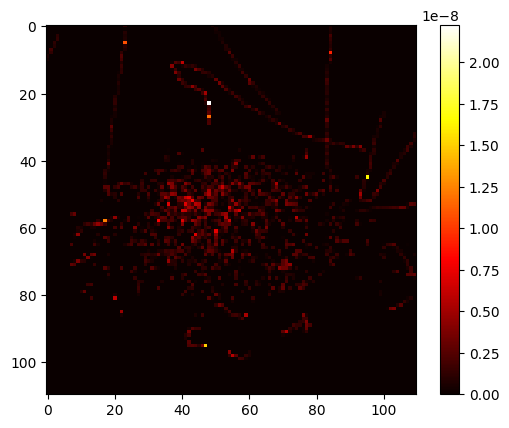

In [85]:
plt.figure()
plt.imshow(arr_dose.sum(axis=0), cmap='hot')
plt.colorbar()
plt.show()

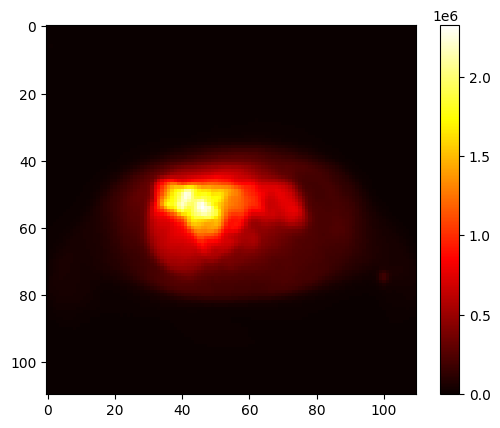

In [66]:
# read the SPECT image
img_spect = sitk.ReadImage('data/patient_SPECT.mhd')
arr_spect = sitk.GetArrayFromImage(img_spect)

# slice of the SPECT activity image
plt.figure()
plt.imshow(arr_spect.sum(axis=0), cmap='hot')
plt.colorbar()
plt.show()

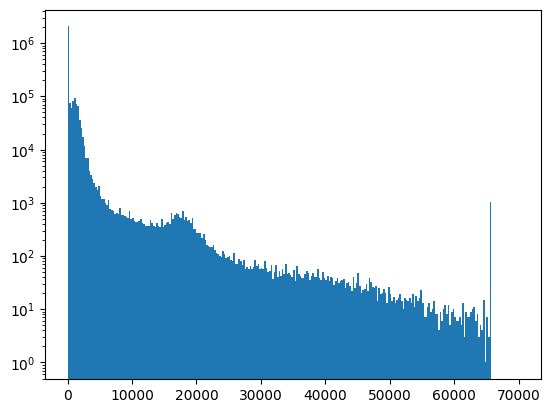

In [94]:
plt.figure()
plt.hist(arr_spect.ravel(), bins=280, range=(0, 70000))
plt.yscale('log')
plt.show()

In [98]:
def show_spect(nslice):
    min_dose_disp = 2e3
    plt.figure()
    a = arr_spect[nslice, :, :]
    b = np.ma.masked_where(a <= min_dose_disp, a)
    plt.imshow(b, cmap='hot', vmin=min_dose_disp, vmax=arr_spect.max())
    # plt.imshow(arr_spect[nslice, :, :], origin='lower', cmap='hot', norm=mplc.LogNorm(vmin=1e4, vmax=arr_spect.max()))
    plt.colorbar()
    plt.show()
    
ipw.interact(show_spect, nslice=(0, arr_spect.shape[2]-1));

interactive(children=(IntSlider(value=54, description='nslice', max=109), Output()), _dom_classes=('widget-int…

In [99]:
# apply a selection on the dose map
cond = arr_spect > 2e3
# print(cond)
dosi = arr_dose[cond].sum()
print('Absorbed dose =', dosi)

Absorbed dose = 1.1237254e-06


# Phase-space (PhSp) analysis

# Reading IAEA phase-space files
You can get IAEA phase-space files from the IAEA database: https://www-nds.iaea.org/phsp/phsp.htmlx
* CyberKnife_IRIS
* ELEKTA_Precise
* SIEMENS_Primus
* Varian_Clinac
* Varian_TrueBeam

# Example with Varian phase-space file

In [100]:
cd ../

/home/mverdier/Documents/IMNC/Gate_SC/Formation_CNRS/2022/Wednesday


In [104]:
pwd

'/home/mverdier/Documents/IMNC/Gate_SC/Formation_CNRS/2022/Wednesday/Gate_Radiotherapy'

In [105]:

# For PHOTON and ELECTRON Varian Native File
dt = np.dtype([('p', np.int8), ('e', np.float32), ('x', np.float32), ('y', np.float32), ('z', np.float32), ('dx', np.float32), ('dy', np.float32)])

# For PHOTON an ELECTRON phase space actor output file (GATE) 
#dt=np.dtype([('p', np.int8), ('e', np.float32), ('x', np.float32), ('y', np.float32), ('z', np.float32), ('dx', np.float32), ('dy', np.float32), ('we', np.float32), ('inc', np.float32) ])

# Test on Reduced PhSp from the IAEA online database
data = np.fromfile('data/Varian_TrueBeam6MV_sample.IAEAphsp', dtype=dt)
print('Number of particles:', len(data))
# data

Number of particles: 1000


In [106]:
# Test on Reduced PhSp from the IAEA online database (first particles)
data=np.fromfile('data/Varian_TrueBeam6MV_sample.IAEAphsp', dtype=dt, count=800)
print('Number of particles:', len(data))

Number of particles: 800


In [107]:
#to save the data to a file
new_data = bytearray(data)
with open("output/Varian_TrueBeam6MV_test.IAEAphsp", "wb") as file:
    file.write(new_data)
    
# Or you can just
data.tofile("output/Varian_TrueBeam6MV_test.IAEAphsp")    


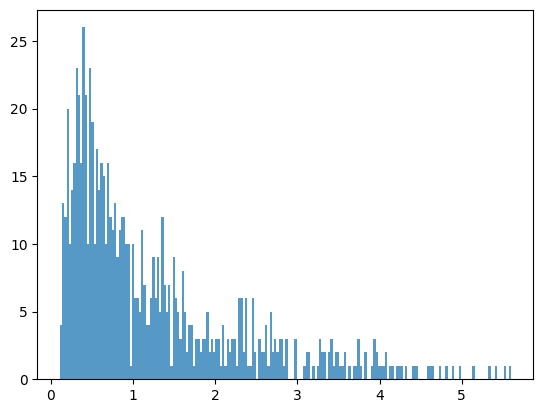

In [108]:


# Plot the energy histogram
x = data['e']

plt.figure()
n, bins, patches = plt.hist(x, bins=200, alpha=0.75)
plt.show()

In [ ]:
# Plot the particle positions
x = data['x']
y = data['y']

plt.figure()
# fig = plt.scatter(x, y, alpha=0.75)
# fig = plt.plot(x, y, '.', alpha=0.75)
fig = plt.hist2d(x, y, bins=50, cmap='hot')
plt.colorbar()
plt.show()

# print(fig)

## Exercise
* save the 1000 particles splitted in 10 different files
* find a method to save the numpy array directly to a file

# PhSp analysis with the example Ex_PhSp
Example based on the exercise **linac** from the GATE exercices:
* Documentation https://davidsarrut.pages.in2p3.fr/gate-exercices-site/docs/exercice4/
* Source https://gitlab.in2p3.fr/davidsarrut/gate-exercices/-/tree/master/linac

## Exercise
* open a terminal and go to the folder Ex_PhSp/
* look at the different files and open the different main*.mac
* run the example with the different main macros  
`Gate mac/main-write-PhS.mac`
* check the output folder and the different files produced  
(some high statistic results are available in results.MD6k/)


* open the ROOT output output-PhS-g.root
* read the tree 'PhaseSpace' and get the data
(see notebook gate_outputs.ipynb for help)
* select and plot the histogram of the particle energies
* select and plot the particle positions
* select and plot the histogram of the particle theta angle

In [109]:
cd Ex_PhSp/

/home/mverdier/Documents/IMNC/Gate_SC/Formation_CNRS/2022/Wednesday/Gate_Radiotherapy/Ex_PhSp


In [110]:
pwd

'/home/mverdier/Documents/IMNC/Gate_SC/Formation_CNRS/2022/Wednesday/Gate_Radiotherapy/Ex_PhSp'

In [127]:
!Gate main-write-PhS.mac

[G4] 
[G4] **************************************************************
[G4]  Geant4 version Name: geant4-10-07-patch-02    (11-June-2021)
[G4]                        Copyright : Geant4 Collaboration
[G4]                       References : NIM A 506 (2003), 250-303
[G4]                                  : IEEE-TNS 53 (2006), 270-278
[G4]                                  : NIM A 835 (2016), 186-225
[G4]                              WWW : http://geant4.org/
[G4] **************************************************************
[G4] 
[Core-0] Initialization of geometry
[Core-0] Initialization of physics
[Core-0] Initialization of actors
[Core-0] 
[Core-0] *************************************************
[Core-0]  GATE version 9.1 (2021)
[Core-0]  Copyright : OpenGATE Collaboration
[Core-0]  Reference : Phys. Med. Biol. 49 (2004) 4543-4561
[Core-0]  Reference : Phys. Med. Biol. 56 (2011) 881-901
[Core-0]  Reference : Med. Phys. 41(6)    (2014)
[Core-0]  http://www.opengatecollaboration.org 

In [ ]:
# complete here

In [123]:

f = uproot.open('output/output-PhS-g.root')
# f = uproot.open('results.MD6k/output-PhS-g.root')

# all trees, branches and leaves names are accessible through the method keys()
print('Trees in the file:')
print(f.keys())
print()
print('Leaves (variables) in the Tree:')
print(f['PhaseSpace'].keys())

data = f[f.keys()[0]].arrays(library="pd").to_records(index=False)
print(data)
print('Number of particles:', len(data))
print(data.dtype)

Trees in the file:
['PhaseSpace;2', 'PhaseSpace;1']

Leaves (variables) in the Tree:
['AtomicNumber', 'Ekine', 'Weight', 'Mass', 'X', 'Y', 'Z', 'dX', 'dY', 'dZ', 'TrackID', 'ParentID', 'EventID', 'RunID']
[(0, 4.548489  , 0.01, 0,  36.69373  ,   0.20610073, 5.e-07,  0.12686831,  0.00293137, -0.9919152 ,  71, 1,    1, 0)
 (0, 3.4269984 , 0.01, 0, -12.769201 ,   1.854649  , 5.e-07, -0.04226361,  0.00128687, -0.9991057 , 178, 1,    7, 0)
 (0, 2.2160728 , 0.01, 0,  32.9628   , -20.63179   , 5.e-07,  0.11058778, -0.07371456, -0.9911289 , 170, 1,    7, 0)
 ...
 (0, 0.24152924, 0.01, 0, -21.22913  ,   5.847843  , 5.e-07, -0.07164813,  0.01807145, -0.99726623,  56, 1, 4999, 0)
 (0, 0.25385118, 0.01, 0,  -3.6473668,  27.42045   , 5.e-07, -0.0125598 ,  0.09041889, -0.99582464,  25, 1, 4999, 0)
 (0, 0.7260191 , 0.01, 0,   4.62121  ,  33.36281   , 5.e-07,  0.01514946,  0.11013062, -0.99380165,  23, 1, 4999, 0)]
Number of particles: 4980
(numpy.record, [('AtomicNumber', '<i4'), ('Ekine', '<f4'), ('

/home/mverdier/.local/lib/python3.8/site-packages/uproot/interpretation/library.py:747: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return (getattr(pandas, "RangeIndex", pandas.Int64Index), pandas.Int64Index)


Number of particles:  4980


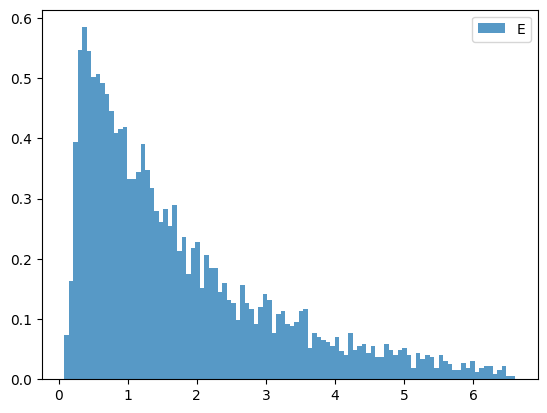

In [124]:
# Plot the energy histogram
x = data['Ekine']

print('Number of particles: ', len(x))
plt.figure()
n, bins, patches = plt.hist(x, bins=100, density=True, alpha=0.75, label='E')
plt.legend()
plt.show()

Number of elements:  4980


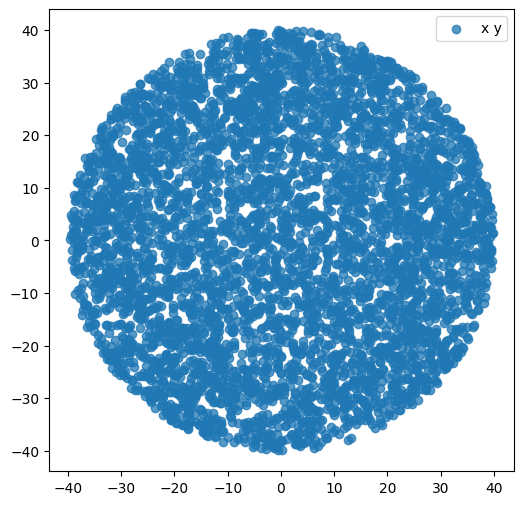

In [125]:
# Plot the x,y positions of the particles
x = data['X']
y = data['Y']

print('Number of elements: ', len(x))
# only keep 500 first elements 
n = x.shape[0]
xn = x[:n]
yn = y[:n]

plt.figure(figsize=(6, 6))
plt.scatter(xn, yn, alpha=0.75, label='x y')
plt.legend()
# plt.hist2d(x, y, bins=100)
# plt.colorbar()
plt.show()

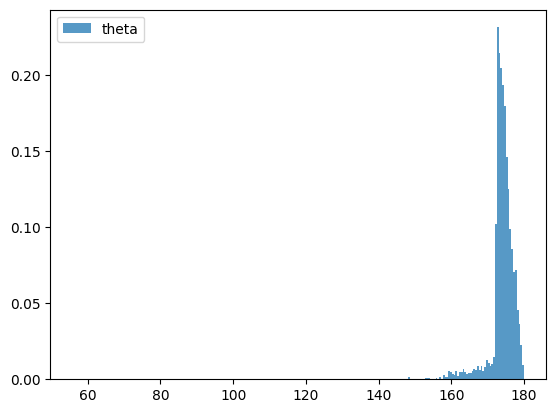

In [126]:
# Plot the theta angle (main direction dZ)
x = np.rad2deg(np.arccos(data['dZ']))

plt.figure()
n, bins, patches = plt.hist(x, bins=250, density=True, alpha=0.75, label='theta')
plt.legend()
plt.show()

# GATE tools
https://github.com/OpenGATE/GateTools

**Tools for [GATE](https://github.com/OpenGATE/Gate/) simulations.**

Install with : `pip install gatetools`

Example of usage:
```
gt_gate_info
gt_image_convert -i input.dcm -o output.mhd
gt_image_convert -i input.mhd -o output_float.mhd -p float
gt_image_arithm -i *.mhd -o output.mhd -O sum
gt_gamma_index dose.mhd gate-DoseToWater.mhd -o gamma.mhd --dd 2 --dta 2.5 -u "%" -T 0.2
```

Use the flag `-h` to get print the help of each tool. Here is the current list of command line tools.

| Tool                          | Comment                                                   |
| -------------                 | -------------                                             |
| `gt_dicom_rt_pbs2gate`        | Convert Dicom RT proton plan for Gate                     |
| `gt_dicom_rt_struct_to_image` | Turn Dicom RT Struct contours into mask image             |
| `gt_gamma_index`              | Compute gamma index between images                        |
| `gt_gate_info`                | Display info about current Gate/G4 version                |
| `gt_image_arithm`             | Pixel- or voxel-wise arithmetic operations                |
| `gt_image_convert`            | Convert image file format (**dicom**, mhd, hdr, nii ... ) |
| `gt_image_crop`               | Crop an image                                             |
| `gt_image_uncertainty`        | Compute statistical uncertainty                           |
| `gt_phsp_convert`             | Convert a phase space file from root to npy               |
| `gt_phsp_info`                | Display information about a phase space file              |
| `gt_phsp_merge`               | Merge two phase space files (output in npy only)          |
| `gt_phps_peaks`               | Try to detect photopeaks (experimental)                   |
| `gt_phsp_plot`                | Plot marginal distributions form a phase space file       |

All tools are also available to be use within your own Python script with, for example:
```
import gatetools as gt
gt.image_convert(inputImage, pixeltype)
```

Tests: run
```
python -m unittest gatetools -v
python -m unittest gatetools.phsp -v
```

Classes and function documentation. Use the following command to open a browser for documentation (it is still not very convenient ; will be improved later).
```
pydoc -b
```

For developers, please have a look at the [readme_dev.md](readme_dev.md) file.